In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%cd ../

/jupyter-lab/repo/daestar


# Import Module

In [66]:
import os
import pickle
import re
from functools import partial
from typing import Any, Dict, Iterable, Tuple

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from IPython.display import Audio as DisplayAudio
from jiwer import cer, wer
from PIL import Image
from pyctcdecode import build_ctcdecoder
from src.base_trainer import get_ckpt_path, get_model_hparams, get_run, load_model_state
from src.dataset.kspon import KSponSpeechDataset, dataloader_collate_fn
from src.dataset.zeroth_korean import ZerothKoreanDataset, zeroth_korean
from src.utils import filter_arguments
from src.wav2vec.trainer import Wav2VecTrainerModel
from torch.utils.data import DataLoader
from torchaudio.utils import download_asset
from tqdm.auto import tqdm
from transformers import (
    AutoFeatureExtractor,
    AutoModelForCTC,
    AutoProcessor,
    AutoTokenizer,
    Wav2Vec2Processor,
    Wav2Vec2ProcessorWithLM,
)
from transformers.models.wav2vec2.configuration_wav2vec2 import Wav2Vec2Config
from transformers.models.wav2vec2.modeling_wav2vec2 import Wav2Vec2ForCTC

from datasets import Audio, load_dataset

# Data Sampling

In [9]:
filepath = "./data/train_data_01/003/106/106_003_0077.flac"
waveform, samplerate = torchaudio.load(filepath)
Audio(waveform.numpy(), rate=samplerate)

In [16]:
SAMPLE_WAV = download_asset(
    "tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
)
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


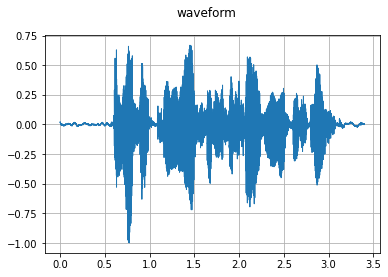

In [25]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)


def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)


plot_waveform(waveform, sample_rate)

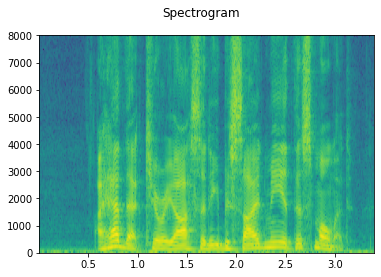

In [32]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)


plot_specgram(waveform, sample_rate)

In [37]:
Audio(waveform.numpy()[0], rate=sample_rate)

# Wav2Vec 2.0

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

In [45]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [49]:
model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /home/jovyan/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [50]:
Audio(SPEECH_FILE)

In [53]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [54]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

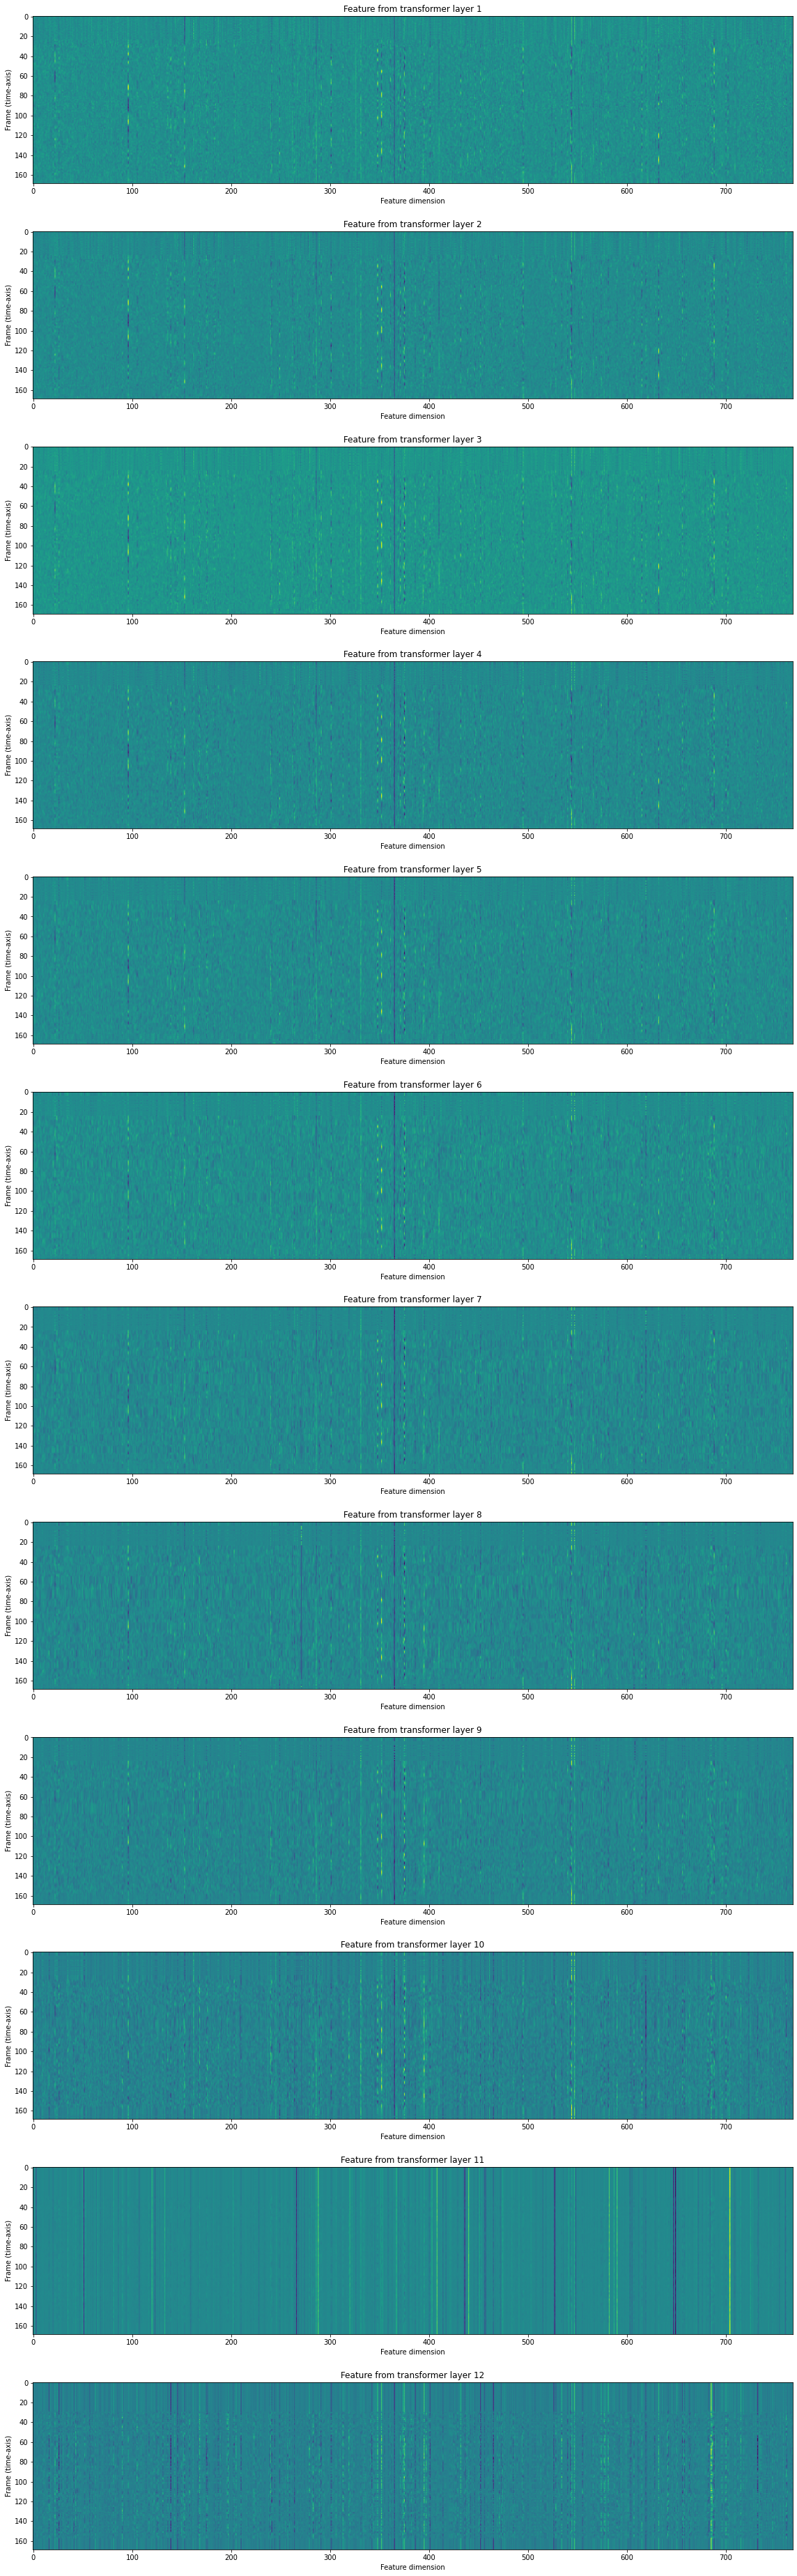

In [57]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [61]:
with torch.inference_mode():
    emission, _ = model(waveform)

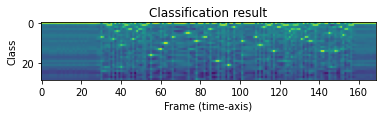

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [64]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [68]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])


decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print(transcript)
Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


# Wav2Vec 2.0 HuggingFace

In [103]:
model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h")
tokenizer = AutoTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [120]:
dataset = load_dataset("common_voice", "en", split='train', streaming=True)
dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate=16_000))
dataset_iter = iter(dataset)
sample = next(dataset_iter)
sample2 = next(dataset_iter)

In [150]:
input_values = feature_extractor(
    sample["audio"]["array"],
    return_tensors="pt",
    padding=True,
    sampling_rate=16_000,
).input_values

In [154]:
with torch.inference_mode():
    logits = model(input_values).logits[0]
    pred_ids = torch.argmax(logits, axis=-1)

In [170]:
outputs = tokenizer.decode(pred_ids)
outputs

'WHY DOES MILISANDRA LOOK LIKE SHE WANTS TO CONSUME JOHN SNOW ON THE RIVT AP THE WALL'

In [165]:
Audio(sample['audio']['array'], rate=16_000)

# Korean ASR

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
model = AutoModelForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)

Downloading:   0%|          | 0.00/214 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/161 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

In [6]:
ds = load_dataset("kresnik/zeroth_korean", "clean")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset zeroth_korean downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/kresnik___zeroth_korean/clean/1.0.1/f6cf96a53d5512525e3113bab8048d36ce268658d6e0c40d45f65dfa3f0bc343. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
def map_to_pred(batch):
    inputs = processor(
        [b["array"] for b in batch["audio"]],
        sampling_rate=16_000,
        return_tensors="pt",
        padding="longest",
    ).input_values.to(device)

    with torch.inference_mode():
        logits = model(inputs).logits.cpu()

    pred_ids = logits.argmax(dim=-1)
    pred = processor.batch_decode(pred_ids)
    batch["pred"] = pred

    return batch


results = ds["test"].map(map_to_pred, batched=True, batch_size=16)

  0%|          | 0/29 [00:00<?, ?ba/s]

In [103]:
gt = results['text']
pred = results['pred']

print(f"WER: {wer(gt, pred):.2%}")
print(f"CER: {cer(gt, pred):.2%}")

WER: 4.76%
CER: 1.79%


# KSponSpeech

## Load Preprocessed Data

In [43]:
df = pd.read_csv("./data/kspon_speech/preprocessed/transcripts.csv")
print(f"# of len: {len(df)}")
df.head()

# of len: 124000


audio_path  \
0  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
1  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
2  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
3  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
4  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   

                                          transcript  
0                                      아 몬 소리야 그건 또.  
1  나는 악습은 원래 없어진다 없어져야 된다고 생각하긴 했는데 근데 그 약간 필요악으로...  
2  그래서 지호랑 계단 올라와서 막 위에 운동하는 기구 있대요. 그서 그걸로 운동 할려구요.  
3  뭐 정신과 병원도 그 약 타서 먹어보고 그 한동안 연락이 안 된 적이 있었단 말이야...  
4                     그게 영 점 일 프로 가정의 아이들과 가정의 모습이야?

In [44]:
df = pd.read_csv("./data/kspon_speech/preprocessed/transcripts.csv")
print(f"# of len: {len(df):,}")
df.head()

# of len: 248,000


audio_path  \
0  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
1  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
2  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
3  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   
4  KsponSpeech_01/KsponSpeech_0001/KsponSpeech_00...   

                                          transcript  
0                                      아 몬 소리야 그건 또.  
1  나는 악습은 원래 없어진다 없어져야 된다고 생각하긴 했는데 근데 그 약간 필요악으로...  
2  그래서 지호랑 계단 올라와서 막 위에 운동하는 기구 있대요. 그서 그걸로 운동 할려구요.  
3  뭐 정신과 병원도 그 약 타서 먹어보고 그 한동안 연락이 안 된 적이 있었단 말이야...  
4                     그게 영 점 일 프로 가정의 아이들과 가정의 모습이야?

In [248]:
i = 0
audio_path = os.path.join("./data/kspon_speech/original", df["audio_path"][i])
transcript = df["transcript"][i]

sr = 16_000

print(transcript)

signal = np.memmap(audio_path, dtype="h", mode="r").astype("float32")

Audio(signal, rate=sr)

아 몬 소리야 그건 또.


In [245]:
dataset = KSponSpeechDataset(filepath='./data/kspon_speech/preprocessed/transcripts.csv')

model_name = "kresnik/wav2vec2-large-xlsr-korean"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForCTC.from_pretrained(model_name).to(device)

inputs = processor(
    [dataset[0][0], dataset[1][0]],
    sampling_rate=16_000,
    return_tensors="pt",
    padding="longest",
)

In [276]:
inputs = processor(
    [dataset[0][0], dataset[1][0]],
    sampling_rate=16_000,
    return_tensors="pt",
    padding="longest",
)

In [262]:
with processor.as_target_processor():
    inputs = processor(
        [dataset[0][2], dataset[1][2]], return_tensors="pt", padding="longest"
    )
inputs

{'input_ids': tensor([[ 886,  859,  901,  859,   42,  931,  775,  859,  469,  848,  859,  189,
         1203, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204,
         1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204,
         1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204,
         1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204,
         1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204, 1204],
        [ 552,  227,  859,   36,  596,  880,  859,  731,  959,  859,  346, 1083,
          702,  962,  859,  346, 1083,  547,  775,  859,  318,  962,  261,  859,
          802,  433, 1178,  725,  859,   14,  227,  171,  859,  125,  171,  859,
          469,  859,  611,  656,  859,  717,   86,   36,  393,  836,  859, 1178,
          552,  859,  532,  590,  362,  880,  859,  517, 1083,  775,  859,  733,
          780,  669, 1203,  859,  232,  859,  967,    4,  859,   26,  261, 1203]]), 'attention

In [240]:
with torch.inference_mode():
    logits = model(inputs.to(device)).logits.cpu()

pred_ids = logits.argmax(dim=-1)
pred = processor.batch_decode(pred_ids)
pred

['봉 서리 아 건도', '나는 학습은 원로 없어진다 없어 제야 된다고 생각하기는 내금데 그가 필요학기로 하 정도 때문 이 사되고물들어가고']

In [316]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    collate_fn=partial(dataloader_collate_fn, processor=processor),
)
batch = next(iter(dataloader))

In [300]:
filter_arguments(batch[0], model.forward)

{'input_values': tensor([[-0.0255, -0.0255, -0.0231,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0142,  0.0142,  0.0142,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0026,  0.0015,  0.0038,  ...,  0.0180,  0.0186,  0.0191],
         ...,
         [-0.0062, -0.0048, -0.0034,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0030, -0.0006,  0.0017,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0102,  0.0091,  0.0102,  ...,  0.0000,  0.0000,  0.0000]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}

In [322]:
ctc_loss = nn.CTCLoss(blank=processor.tokenizer.pad_token_id)

with torch.inference_mode():
    inputs = filter_arguments(batch[0], model.forward)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)

loss = ctc_loss(
    outputs.logits.log_softmax(dim=-1).transpose(1, 0),
    batch[1]["input_ids"].to(device),
    torch.full(size=(16,), fill_value=outputs.logits.shape[1], dtype=torch.long).to(
        device
    ),
    batch[1]["lengths"].to(device),
)

In [32]:
config = Wav2Vec2Config(vocab_size=processor.tokenizer.vocab_size)
model = Wav2Vec2ForCTC(config=config)

In [8]:
model_name = "kresnik/wav2vec2-large-xlsr-korean"
processor = AutoProcessor.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
dataset = KSponSpeechDataset(filepath='./data/kspon_speech/preprocessed/transcripts.csv')

In [74]:
total_time = 0
sampling_rate = 16_000
for i, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = os.path.join(data_dir, row["audio_path"])
    signal = np.memmap(audio_path, dtype="h", mode="r").astype("float32")
    total_time += signal.shape[0] * (1 / sampling_rate)

print(f"total time: {total_time / 3600:.2f} h")

  0%|          | 0/248000 [00:00<?, ?it/s]

total time: 386.30 h


---

In [3]:
filepath = "./data/kspon_speech/preprocessed/transcripts.csv"
kspon_dataset = KSponSpeechDataset(filepath)

cache_dir = "./data/huggingface/datasets"
zeroth_dataset = ZerothKoreanDataset(cache_dir=cache_dir)

Reusing dataset zeroth_korean (./data/huggingface/datasets/zeroth_korean/clean/1.0.1/9a94084b20a2178356409c482b07920a4ac8b4571d2e298e044ea58c8ca00a87)


In [30]:
i = np.random.randint(len(kspon_dataset))

print(i)
print(kspon_dataset.df["transcript"][i])
DisplayAudio(kspon_dataset[i][0], rate=16_000)

117197
아 시코르. 어? 그럼 홍대에도 있나? 홍대에 시코르 있어.


In [33]:
i = np.random.randint(len(zeroth_dataset))

print(i)
print(zeroth_dataset.df["transcript"][i])
DisplayAudio(zeroth_dataset[i][0], rate=16_000)

5968
눈 주변에는 부종과 검붉은 반점이 피어 있고 볼과 이마는 딱딱하게 굳어 마치 가면을 쓴 듯했다


In [46]:
run_id = "2569d5ef49bd4e3dac956c787ba79ab3"
hparams = get_model_hparams("./logs", run_id, Wav2VecTrainerModel.MODEL_HPARAMS)

model_name = "kresnik/wav2vec2-large-xlsr-korean"
# model_name = "Taeham/wav2vec2-ksponspeech"
processor = AutoProcessor.from_pretrained(model_name)

# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

model = Wav2Vec2ForCTC(
    Wav2Vec2Config(
        vocab_size=processor.tokenizer.vocab_size,
        pad_token_id=processor.tokenizer.pad_token_id,
        **filter_arguments(hparams, Wav2Vec2Config),
    )
).to(device)

# model = Wav2Vec2ForCTC.from_pretrained(model_name)

ckpt_path = get_ckpt_path("./logs", run_id, load_best=True)
load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [99]:
i = 45

dataset = zeroth_dataset
# dataset = kspon_dataset

signal = processor(
    [dataset[i][0]], sampling_rate=16_000, return_tensors="pt", padding="longest"
)

with processor.as_target_processor():
    transcripts = processor([dataset[i][2]], return_tensors="pt", padding="longest")

with torch.inference_mode():
    signal = {k: v.to(device) for k, v in signal.items()}
    logits = model(**signal).logits
    pred_ids = logits.argmax(dim=-1)
    predictions = processor.batch_decode(pred_ids)

print("gt:        ", dataset[i][2])
print("prediction:", predictions[0])

DisplayAudio(dataset[i][0], rate=16_000)

gt:         그리고는 직접 연락해보겠다고 했지만 얼마 후 연락이 닿지 않는다는 확인 불가능한 말만 되풀이했습니다
prediction: 그리고는 직접 연락해보겠다고 하지만 얼마 후 연락이 닿지 않는 다 확인 불가능한 말만 대풀이했습니다


In [168]:
vocab_dict = processor.tokenizer.get_vocab()
special_tokens = [t for t in processor.tokenizer.all_special_tokens if t != "[PAD]"]
sort_vocab = sorted((value, key) for (key, value) in vocab_dict.items())
vocab = [
    re.sub(r"(\||\[PAD\])", " ", x[1]) if x[1] not in special_tokens else "_"
    for x in sort_vocab
]

In [ ]:
%%time

model_path = "./data/zeroth_korean/zeroth.lm.fg.arpa"
decoder = build_ctcdecoder(vocab[:-2], kenlm_model_path=model_path, alpha=0.5, beta=1.0)

In [134]:
decoder.decode(logits[0].numpy())

'그쏘고는돌직접돌연락해보겠식고돌레지만돌늘마돌후돌연락이돌닿지돌않는돌식돌확인돌불가능한돌말만돌대총이했습니식'